# Model objects and predicting whole brain activity

Model objects are supereeg’s class that contains the correlation model that we use to reconstruct full-brain activity from recordings at an impoverished set of locations. The supereeg package offers a several pre-compiled models that you can use to reconstruct brain activity. We also provide several ways of creating or specifying your own model. This tutorial will review how to use the pre-made models included in this package and make a new model from scratch.


# Load in the required libraries

In [1]:
import warnings
#warnings.simplefilter("ignore")
%matplotlib inline
import supereeg as se
import numpy as np
%load_ext autoreload
%autoreload 2

First, let’s load in our default model, example_model, that we made from the pyFR dataset resampled to 20mm cubic voxels.

In [2]:
model = se.load('example_model')

other model options: - pyFR_k10r20_6mm: correlation model trained on the pyFR dataset and resampled to 6mm cubic voxels

- pyFR_k10r20_20mm: full name of example_model (either string will load the same model)


# Initialize model objects

Model objects can be initialized by passing any of the following to the Model class instance initializer: 
- a path to an existing saved model object (ending in .mo)
- an existing model object (this makes a copy of the existing model object)
- a Brain object or Nifti object [or paths to saved Brain objects (.bo) or Nifti objects (.nii)]
- a string corresponding to any of the built-in example files, of any format (any datatype may be converted to a Model object)

In addition, new model objects may be created via the load function (which loads any of the toolbox-supported data types) and specifying return_type='mo'

In [3]:
nii_mo = se.Model('example_nifti')

sizeof_hdr should be 348; set sizeof_hdr to 348
data code 26996 not recognized; not attempting fix
sizeof_hdr should be 348; set sizeof_hdr to 348
data code 26996 not recognized; not attempting fix


HeaderDataError: data code 26996 not recognized

Or:

In [4]:
nii_mo = se.load('example_nifti', return_type='mo')

sizeof_hdr should be 348; set sizeof_hdr to 348
data code 26996 not recognized; not attempting fix
sizeof_hdr should be 348; set sizeof_hdr to 348
data code 26996 not recognized; not attempting fix


HeaderDataError: data code 26996 not recognized

# Model object methods

There are a few other useful methods on a model object:

## mo.info()

This method will give you a summary of the model object:

In [5]:
model.info()

Number of locations: 210
Number of subjects: 67
RBF width: 20
Date created: Mon Dec 23 07:29:19 2024
Meta data: {'stable': True}


# mo.plot_data()

This method will plot your model.

The model is comprised of a number of fields. The most important are the model.numerator and model.denominator. Dividing these two fields gives a matrix of z-values, where the value in each cell represents the covariance between every model brain location with every other model brain location. To view the model, simply call the model.plot method. This method wraps seaborn.heatmap to plot the model (transformed from z to r), so any arguments that seaborn.heatmap accepts are supported by model.plot.


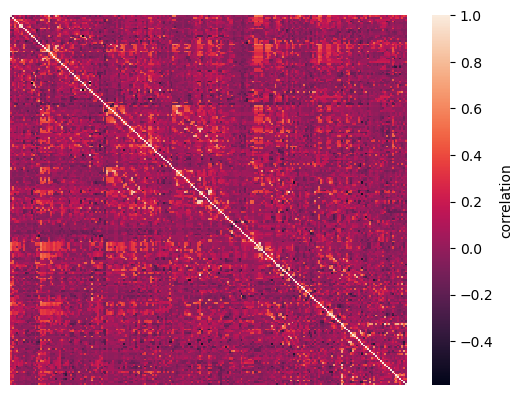

<Axes: >

In [6]:
model.plot_data(xticklabels=False, yticklabels=False)

# mo.plot_locs()

This method will plot the locations in your model.

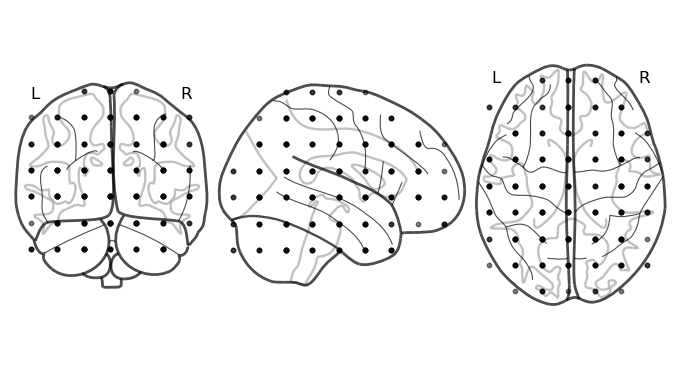

In [7]:
model.plot_locs()

# mo.update()

This method allows you to update the model with addition subject data.

To do this, we can use the update method, passing a new subjects data as a brain object. First, let’s load in an example subjects data:

In [8]:
bo = se.load('example_data')
bo.info()

Number of electrodes: 64
Recording time in seconds: [ 5.3984375 14.1328125]
Sample Rate in Hz: [np.uint16(256), np.uint16(256)]
Number of sessions: 2
Date created: Fri Mar  9 17:09:35 2018
Meta data: {'patient': np.str_('CH003')}


Now you can update the model with that brain object. This can be done either in place using inplace = True, or you can save a new updated model:

In [9]:
updated_model = model.update(bo, inplace=False)
updated_model.info()

Number of locations: 274
Number of subjects: 68
RBF width: 20
Date created: Mon Dec 23 07:29:19 2024
Meta data: {'stable': True}


You can also update the model by adding two model objects together.

In [10]:
mo_bo = se.Model(bo, locs=updated_model.get_locs(), n_subs=1)
mo_mo = se.Model(model, locs=updated_model.get_locs(), n_subs=67)
added_model = mo_mo + mo_bo

In [11]:
np.allclose(added_model.get_model(), updated_model.get_model())

True

You can subtract models too, but once this operation is performed, you won’t be able to update the model in the future.

In [12]:
new_locs = se.simulate_locations(n_elecs=100)
mo_bo = se.Model(bo, locs=new_locs, n_subs=1)
add_model = mo_bo + mo_bo
sub_model = add_model - mo_bo

In [13]:
np.allclose(mo_bo.get_model(), sub_model.get_model())

True

In [14]:
try:
    assert sub_model + add_model
except AssertionError:
    assert True == True

Note that the model is now comprised of 67 subjects, instead of 66 before we updated it.

# mo.get_model()

This method returns the model in the form of a correlation matrix.

In [15]:
updated_model.get_model()

array([[ 1.        , -0.09811393,  0.18961899, ...,  0.27256808,
         0.36030263,  0.25768555],
       [-0.09811393,  1.        ,  0.23203525, ...,  0.37158962,
         0.07614721, -0.01200328],
       [ 0.18961899,  0.23203525,  1.        , ...,  0.01061833,
        -0.02072749,  0.1670675 ],
       ...,
       [ 0.27256808,  0.37158962,  0.01061833, ...,  1.        ,
         0.08097902,  0.15267173],
       [ 0.36030263,  0.07614721, -0.02072749, ...,  0.08097902,
         1.        , -0.03895988],
       [ 0.25768555, -0.01200328,  0.1670675 , ...,  0.15267173,
        -0.03895988,  1.        ]])

# mo.save(fname='something')

This method will save the brain object to the specified file location. The data will be saved as a ‘bo’ file, which is a dictionary containing the elements of a brain object saved in the hd5 format using deepdish.

In [16]:
model.save(fname='model_object')

# Creating a new model

In addition to including a few pre-made models in the supereeg package, we also provide a way to construct a model from scratch.

## Created from a list of brain objects:

For example, if you have an ECoG dataset, we provide a way to construct a model that will predict whole brain activity. The more subjects you include in the model, the better it will be! To create a model, first you’ll need to format your subject data into brain objects. For the purpose of demonstration, and to highlight the “simulation” features of the toolbox, we will generate a synthetic ECoG dataset. Specifically, we’ll simulate data from 100 locations from each of 10 subjects and construct the model from that data:

In [17]:
# simulate 100 locations
locs = se.simulate_locations(100)

# simulate 10 brain objects to create a model
n_subs = 10
model_bos = [se.simulate_model_bos(n_samples=1000, sample_rate=1000, sample_locs=20,
                                   locs=locs, cov='toeplitz') for x in range(n_subs)]

model_bos[0].info()

Number of electrodes: 20
Recording time in seconds: [1.]
Sample Rate in Hz: [1000]
Number of sessions: 1
Date created: Mon Dec 23 07:30:03 2024
Meta data: {}


As you can see above, each simulated subject has 10 (randomly placed) ‘electrodes,’ with 1 second of data each. To construct a model from these brain objects, simply pass them to the se.Model class, and a new model will be generated:

In [18]:
new_model = se.Model(data=model_bos, locs=locs)
new_model.info()

Number of locations: 100
Number of subjects: 1
RBF width: 20
Date created: Mon Dec 23 07:30:04 2024
Meta data: {'stable': True}


## Created by adding to model object fields:

Another option is to add a model directly.

You can add your model to model.data and add the corresponding locations for the model in the field locs.

Another option, allows you to add your model to model.numerator, which comprises the sum of the z-scored correlation matrices over subjects. The model.denominator field comprises the sum of the number of subjects contributing to each matrix cell in the model.numerator field. You can add the locations for the model in the field locs and the number of subjects to n_subs.

In this next example, we’re constructing the model from a toeplitz matrix with 10 subjects using 100 simulated locations. We created the matrix using the function, se.create_cov and added it to the model.data field.

You can also create a custom covariance matrix in se.create_cov by simply passing numpy array as and that is number of locations by number of locations to cov and the number of location to n_elecs.

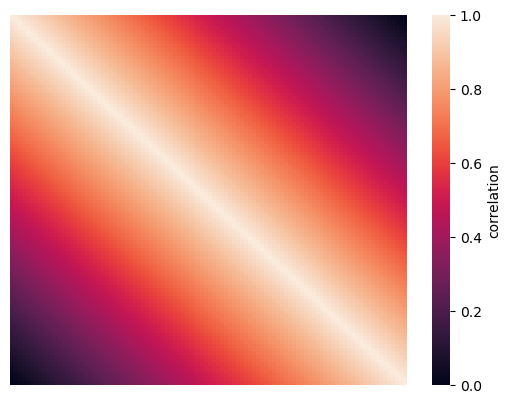

<Axes: >

In [19]:
R = se.create_cov(cov='toeplitz', n_elecs=len(locs))
p = 10
toe_model = se.Model(data=R, locs=locs, n_subs=p)
toe_model.plot_data(xticklabels=False, yticklabels=False)

In this example we simulated 100 MNI locations. However coordinates can also be derived by specifiying a template nifti file.

In [20]:
# new_model = se.Model(bos, template='/your/custom/MNI_template.nii')

# Predicting whole brain activity

## mo.predict()

Now for the magic. supereeg uses *gaussian process regression* to infer whole brain activity given a smaller sampling of electrode recordings. To predict activity, simply call the predict method of a model and pass the subjects brain activity that you’d like to reconstruct:

## mo.predict(nearest_neighbor=True)

As default, the nearest voxel for each subject’s electrode location is found and used as revised electrodes location matrix in the prediction. If nearest_neighbor is set to False, the original locations are used in the prediction.

## mo.predict(force_update=False)

As default, the model is not updated with the subject’s correlation matrix. By setting force_update to True, you will update the model with the subject’s correlation matrix.

BEFORE
------
Number of electrodes: 64
Recording time in seconds: [ 5.3984375 14.1328125]
Sample Rate in Hz: [np.uint16(256), np.uint16(256)]
Number of sessions: 2
Date created: Fri Mar  9 17:09:35 2018
Meta data: {'patient': np.str_('CH003')}


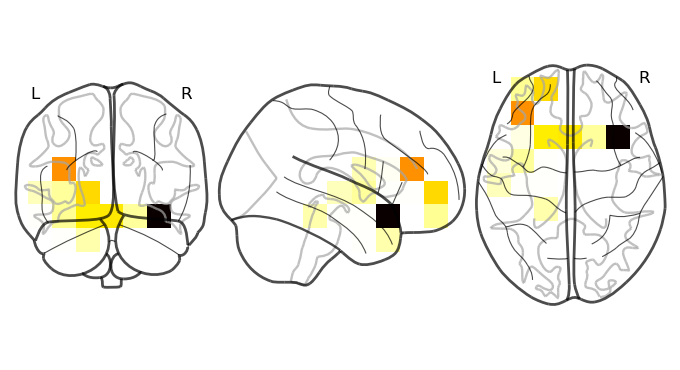

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [21]:
# plot a slice of the original data
print('BEFORE')
print('------')
bo.info()
nii = bo.to_nii(template='gray', vox_size=20)
nii.plot_glass_brain()

# voodoo magic
bor = model.predict(bo, nearest_neighbor=False, force_update=True)


# plot a slice of the whole brain data
print('AFTER')
print('------')
bor.info()
nii = bor.to_nii(template='gray', vox_size=20)
nii.plot_glass_brain()

Using the supereeg algorithm, we’ve ‘reconstructed’ whole brain activity from a smaller sample of electrodes.

You can plot locations of the new brain object with predicted activity. Observed locations are in black and predicted locations are in red.

In [ ]:
bor.plot_locs()